# Intra/extrapolation analyses and visualizations

Testing how well DNNs interpolate and extrapolate with GMF stimuli, training on a restricted range of rotation (around y-axis). Used to create "extrapolation" figure for Wellcome grant.

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
from matplotlib import cm
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from statsmodels.nonparametric.smoothers_lowess import lowess


def fix_bytes(df):
    """Fix bytes (by converting them to simple strings) in a dataframe."""
    for col in df.columns:
        if df[col].dtype == object:
            df[col] = df[col].str.replace("b'", '').str.replace("'", '')

    return df

def plot_lowess_line(ax, df, c):
    """Plot a lowess line on a given axis and shade the +-1 SD area around it with color `c`."""
    tmp = df.groupby('yr').mean().reset_index()
    out = lowess(tmp['id_truepred'], tmp['yr'])
    sd = df.groupby('yr').std()['id_truepred'] / np.sqrt(df.groupby('yr').count()['id_truepred'])
    ax.plot(out[:, 0], out[:, 1], c=c)
    ax.fill_between(out[:, 0], out[:, 1] - sd, out[:, 1] + sd, alpha=0.5, facecolor=c)
    return ax

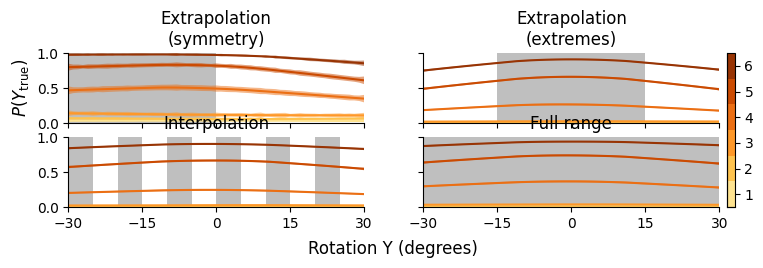

In [4]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(10, 2), sharex=True, sharey=True)
axes = axes.flatten()

ax = axes[0]
ax.axvspan(-30, 0, facecolor='grey', alpha=0.5)
ax.set_title("Extrapolation\n(symmetry)")
ax.set_xlim(-30, 30)
ax.set_xticks([-30, -15, 0, 15, 30])
ax.set_xlabel('')
ax.set_ylim(0.5, 1)

paths = sorted(list(Path('../results').glob('ResNet6_dataset-gmf_112x112_emo_target-id_yr-left_epoch-050_layer-*_preds.csv')))
paths = [p for p in paths if 'input' not in str(p)]
cmap = sns.color_palette("YlOrBr", n_colors=len(paths) + 1)[1:]

for i, path in enumerate(paths):
    df = fix_bytes(pd.read_csv(path))
    plot_lowess_line(ax, df, c=cmap[i])
    
ax = axes[1]
ax.axvspan(-15, 15, facecolor='grey', alpha=0.5)
ax.set_title("Extrapolation\n(extremes)")

paths = sorted(list(Path('../results').glob('ResNet6_dataset-gmf_112x112_emo_target-id_yr-extrap_epoch-050_layer-*_preds.csv')))
paths = [p for p in paths if 'input' not in str(p)]
for i, path in enumerate(paths):
    df = fix_bytes(pd.read_csv(path))
    plot_lowess_line(ax, df, c=cmap[i])

ax = axes[2]
ax.set_title("Interpolation")

start = -30
for i in range(7):
    ax.axvspan(start, start + 5, facecolor='grey', alpha=0.5)
    start += 10

paths = sorted(list(Path('../results').glob('ResNet6_dataset-gmf_112x112_emo_target-id_yr-interp_epoch-050_layer-*_preds.csv')))
paths = [p for p in paths if 'input' not in str(p)]
for i, path in enumerate(paths):
    df = fix_bytes(pd.read_csv(path))
    plot_lowess_line(ax, df, c=cmap[i])

ax = axes[3]
ax.axvspan(-30, 30, facecolor='grey', alpha=0.5)
ax.set_title("Full range")

paths = sorted(list(Path('../results').glob('ResNet6_dataset-gmf_112x112_emo_target-id_epoch-050_layer-*_preds.csv')))
paths = [p for p in paths if 'input' not in str(p)]
for i, path in enumerate(paths):
    df = fix_bytes(pd.read_csv(path))
    plot_lowess_line(ax, df, c=cmap[i])

axes[0].set_ylabel('$P(Y_\mathrm{{true}})$', fontsize=12)
axes[1].set_yticks([0, 0.5, 1])

# Custom discrete colorbar
bounds = np.arange(1, len(cmap) + 1) + 0.5
cmap_ = mpl.colors.ListedColormap(cmap)
norm = mpl.colors.BoundaryNorm(bounds, len(cmap))
mapp = cm.ScalarMappable(cmap=cmap_, norm=mpl.colors.NoNorm())
cbar = fig.colorbar(mapp, ax=axes, pad=0.01)
cbar.set_ticks(cbar.get_ticks()[:-1])
cbar.set_ticklabels(range(1, len(cmap) + 1))

fig.text(0.45, -0.1, 'Rotation Y (degrees)', ha='center', va='center', fontsize=12)
sns.despine()
fig.savefig('./figures/extrapolation.pdf', bbox_inches='tight')